EXPLORATORY DATA ANALYSIS:

Below is where I pull and clean the data. Both the NCAA and the NBA datasets are from Kaggle, but the NCAA Dataset is a bigquery set, so my steps in this process:

1) Create SQL query to pull data from google cloud
2) Export the data to a csv for use without constantly pulling and reauthenticating
3) Merge the NBA statistics to the additional NBA player data to get their college information
4) Merge the NBA and NCAA data on name and college attended
5) Perform data analysis and clean data based on results

In [2]:
#from google.cloud import bigquery as bq
#client = bq.Client()
#sql_query = """
#SELECT
#  ncaa1.full_name,
#  COUNT(ncaa1.game_id) AS num_games,
#  ncaa1.season,
#  team.turner_name,
#  AVG(CAST(ncaa1.minutes_int64 AS FLOAT64)) AS avg_minutes,
#  AVG(CAST(ncaa1.two_points_made AS FLOAT64))/AVG(CAST(ncaa1.minutes_int64 AS FLOAT64)) AS avg_two_points_made_pm,
#  AVG(CAST(ncaa1.field_goals_att AS FLOAT64) - CAST(ncaa1.field_goals_made AS FLOAT64))/AVG(CAST(ncaa1.minutes_int64 AS FLOAT64)) AS avg_field_goals_miss_pm,
#  AVG(CAST(ncaa1.three_points_made AS FLOAT64))/AVG(CAST(ncaa1.minutes_int64 AS FLOAT64)) AS avg_three_points_made_pm,
#  AVG(CAST(ncaa1.free_throws_made AS FLOAT64))/AVG(CAST(ncaa1.minutes_int64 AS FLOAT64)) AS avg_free_throws_made_pm,
#  AVG(CAST(ncaa1.free_throws_att AS FLOAT64) - CAST(ncaa1.free_throws_made AS FLOAT64))/AVG(CAST(ncaa1.minutes_int64 AS FLOAT64)) AS avg_free_throws_miss_pm,
#  AVG(CAST(ncaa1.offensive_rebounds AS FLOAT64))/AVG(CAST(ncaa1.minutes_int64 AS FLOAT64)) AS avg_off_rebounds_pm, 
#  AVG(CAST(ncaa1.defensive_rebounds AS FLOAT64))/AVG(CAST(ncaa1.minutes_int64 AS FLOAT64)) AS avg_def_rebounds_pm,
#  AVG(CAST(ncaa1.assists AS FLOAT64))/AVG(CAST(ncaa1.minutes_int64 AS FLOAT64)) AS avg_assists_pm,
#  AVG(CAST(ncaa1.turnovers AS FLOAT64))/AVG(CAST(ncaa1.minutes_int64 AS FLOAT64)) AS avg_turnovers_pm,
#  AVG(CAST(ncaa1.steals AS FLOAT64))/AVG(CAST(ncaa1.minutes_int64 AS FLOAT64)) AS avg_steals_pm,
#  AVG(CAST(ncaa1.blocks AS FLOAT64))/AVG(CAST(ncaa1.minutes_int64 AS FLOAT64)) AS avg_block_pm,
#  AVG(CAST(ncaa1.personal_fouls AS FLOAT64))/AVG(CAST(ncaa1.minutes_int64 AS FLOAT64)) AS avg_personal_fouls_pm
#  FROM `bigquery-public-data.ncaa_basketball.mbb_players_games_sr` ncaa1
#  INNER JOIN (SELECT full_name, MAX(season) AS max_season FROM`bigquery-public-data.ncaa_basketball.mbb_players_games_sr` GROUP BY full_name) ncaa2
#  ON ncaa1.full_name = ncaa2.full_name
#  AND ncaa1.season = ncaa2.max_season
#  INNER JOIN `bigquery-public-data.ncaa_basketball.mbb_teams` team
#  ON ncaa1.team_id = team.id
#  WHERE ncaa1.minutes_int64 > 0
#GROUP BY full_name, season, turner_name;
#"""
#ncaa_stats_pm = client.query(sql_query).to_dataframe()



The cell above was to pull the NCAA data. It was available as a Google big query data set. I found the dataset through kaggle and used my key and SQL to pull the data. Changed the data to per minute since I wanted to make a comparsion to PER, which is also per unit of time. I also wanted to specifically use the last season the player was in the NCAA, since this would probably be the most correlated to their performace in the NBA, so I did an inner join with player and max season.

In [3]:
#ncaa_stats_pm.to_csv('ncaa_stats_pm.csv')

#This converted this dataframes to csvs so I could pull from them later (they're now in the project folder which is why I commented out these cells)

In [32]:
%matplotlib inline
import pandas as pd
ncaa_stats_pm = pd.read_csv('ncaa_stats_pm.csv')
nba_stat = pd.read_csv('Seasons_Stats.csv')
nba_player = pd.read_csv('player_data.csv')
nba_stats = pd.merge(nba_stat, nba_player, left_on = ['Player'], right_on = ['name'], how = 'inner')
print(nba_stats)

#This is reading all of my csv, then I merged the nba stats with the player data, this is so I make sure that when I join the
#nba and ncaa data, I get the right data by comparing the college

      Year                 Player Pos  Age   Tm   G  GS    MP   PER    TS%  \
0     2011            Jeff Adrien  PF   24  GSW  23   0   196  11.3  0.457   
1     2012            Jeff Adrien  PF   25  HOU   8   0    63  11.2  0.493   
2     2013            Jeff Adrien  PF   26  CHA  52   5   713  13.4  0.493   
3     2014            Jeff Adrien  PF   27  TOT  53  12   961  17.4  0.553   
4     2014            Jeff Adrien  PF   27  CHA  25   0   256  14.9  0.559   
5     2014            Jeff Adrien  PF   27  MIL  28  12   705  18.4  0.552   
6     2015            Jeff Adrien  PF   28  MIN  17   0   215  14.2  0.494   
7     2011          Arron Afflalo  SG   25  DEN  69  69  2324  13.6  0.620   
8     2012          Arron Afflalo  SG   26  DEN  62  62  2086  14.7  0.584   
9     2013          Arron Afflalo  SF   27  ORL  64  64  2307  13.0  0.527   
10    2014          Arron Afflalo  SG   28  ORL  73  73  2552  16.0  0.574   
11    2015          Arron Afflalo  SG   29  TOT  78  72  2502  1

In [33]:
nba_stats['PER*MP'] = nba_stats['PER'] * nba_stats['MP']
nba_per = nba_stats[['Player','college', 'MP', 'PER*MP']].groupby(['Player', 'college']).sum()
#I am multiplying PER * minutes played so I can later divide by minutes played to get overall PER as a weighted average based on time played

In [34]:
ncaa_stats_pm = ncaa_stats_pm.drop(columns = 'Unnamed: 0')

#Removing Initial index column


In [35]:
ncaa_nba_pm = pd.merge(ncaa_stats_pm, nba_per, left_on = ['full_name','turner_name'], right_on = ['Player','college'], how = 'inner')

#Merging the NCAA and NBA datasets based on the name of the player and team they were on

In [36]:
ncaa_nba_pm['PER'] = ncaa_nba_pm['PER*MP'] / ncaa_nba_pm['MP']
ncaa_nba_pm.describe()

#Calculating weighted PER

,num_games,season,avg_minutes,avg_two_points_made_pm,avg_field_goals_miss_pm,avg_three_points_made_pm,avg_free_throws_made_pm,avg_free_throws_miss_pm,avg_off_rebounds_pm,avg_def_rebounds_pm,avg_assists_pm,avg_turnovers_pm,avg_steals_pm,avg_block_pm,avg_personal_fouls_pm,MP,PER*MP,PER
count,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000
mean,32.523438,2013.976562,30.293919,0.130922,0.180184,0.036385,0.106594,0.038801,0.054566,0.144411,0.076217,0.062514,0.035288,0.031632,0.080359,1544.250000,19520.473438,10.795642
std,7.945647,0.846157,5.589820,0.043628,0.046847,0.029968,0.035443,0.018091,0.033829,0.054171,0.049491,0.017390,0.019488,0.030348,0.030661,1868.008903,27185.265020,6.624581
min,3.000000,2013.000000,7.481481,0.044150,0.043676,0.000000,0.030788,0.006158,0.006319,0.062181,0.004950,0.016010,0.006774,0.000716,0.030769,3.000000,-395.600000,-17.600000
25%,33.000000,2013.000000,28.055530,0.100303,0.147152,0.008272,0.080932,0.025203,0.024217,0.098142,0.042700,0.052120,0.023011,0.008504,0.060831,169.250000,1888.850000,8.003281
50%,35.000000,2014.000000,31.675000,0.122372,0.179350,0.034465,0.106793,0.037253,0.048448,0.138220,0.057788,0.061373,0.031822,0.019591,0.074779,749.500000,7575.450000,10.700300
75%,36.000000,2015.000000,34.233929,0.157881,0.215047,0.062001,0.129298,0.049358,0.084258,0.179611,0.101009,0.074844,0.043128,0.044304,0.087884,2282.500000,26402.125000,13.648256
max,40.000000,2015.000000,39.942857,0.251212,0.292308,0.141280,0.218750,0.112821,0.131478,0.293666,0.235812,0.108379,0.147170,0.117881,0.208520,8862.000000,138503.600000,44.300000


In [37]:
ncaa_nba_pm = ncaa_nba_pm.loc[(ncaa_nba_pm['num_games'] >= 20)]
ncaa_nba_pm.describe()
#It seems like some of the people had very few NCAA games. I want to remove these since these people didn't really get the chance to prove themselves in the NCAA.
#Based on this, I set a game minimum of 20, which is closer to how many games are played. Also I made sure their NCAA time per game was at least 20, so that we get a good amount of playing time to reference

,num_games,season,avg_minutes,avg_two_points_made_pm,avg_field_goals_miss_pm,avg_three_points_made_pm,avg_free_throws_made_pm,avg_free_throws_miss_pm,avg_off_rebounds_pm,avg_def_rebounds_pm,avg_assists_pm,avg_turnovers_pm,avg_steals_pm,avg_block_pm,avg_personal_fouls_pm,MP,PER*MP,PER
count,118.000000,118.000000,118.000000,118.000000,118.000000,118.000000,118.000000,118.000000,118.000000,118.000000,118.000000,118.000000,118.000000,118.000000,118.000000,118.000000,118.000000,118.000000
mean,34.550847,2014.042373,30.154931,0.129751,0.179297,0.037860,0.105674,0.037762,0.053894,0.143299,0.077338,0.062455,0.035620,0.031048,0.080213,1540.372881,19411.155085,10.500601
std,3.589151,0.830961,5.673768,0.043605,0.045527,0.029884,0.033277,0.017199,0.034163,0.054449,0.049327,0.017208,0.019358,0.030241,0.030151,1789.887533,26375.795847,6.055124
min,20.000000,2013.000000,7.481481,0.044150,0.043676,0.000000,0.030788,0.006158,0.006319,0.062181,0.004950,0.016010,0.006774,0.000716,0.034796,7.000000,-395.600000,-17.600000
25%,33.000000,2013.000000,28.037558,0.097546,0.145844,0.012233,0.081727,0.024057,0.023726,0.096649,0.043848,0.050802,0.023683,0.008100,0.060741,196.500000,1954.725000,7.954840
50%,35.000000,2014.000000,31.587879,0.121321,0.179350,0.035519,0.106793,0.035318,0.044773,0.137324,0.057788,0.061152,0.032094,0.019330,0.074779,775.000000,7640.700000,10.600300
75%,36.000000,2015.000000,34.199206,0.155928,0.208146,0.062072,0.129100,0.049336,0.085227,0.179243,0.101650,0.074852,0.043305,0.043216,0.087227,2289.500000,27208.175000,13.605122
max,40.000000,2015.000000,39.942857,0.251212,0.289617,0.141280,0.179487,0.090069,0.131478,0.293666,0.235812,0.108379,0.147170,0.117881,0.208520,8862.000000,138503.600000,30.800000


In [38]:
ncaa_nba_pm['avg_points_pm'] = ncaa_nba_pm['avg_two_points_made_pm']*2 + ncaa_nba_pm['avg_three_points_made_pm']*3 + ncaa_nba_pm['avg_free_throws_made_pm']
ncaa_nba_pm['avg_rebounds_pm'] = ncaa_nba_pm['avg_off_rebounds_pm'] + ncaa_nba_pm['avg_def_rebounds_pm']

#Combined some stats to create stats that are more general just in case my model seems to overfit

In [39]:
ncaa_nba_pm = ncaa_nba_pm.loc[(ncaa_nba_pm['MP'] >= 100)]
ncaa_nba_pm.describe()

#Looking at our earlier data, it seems like there are quite a few people in this list who have had very few minutes in the NCAA or the NBA.
#I decided to exclude these observations since their NBA PERs are probably more highly volatile and aren't indicitive of their value

,num_games,season,avg_minutes,avg_two_points_made_pm,avg_field_goals_miss_pm,avg_three_points_made_pm,avg_free_throws_made_pm,avg_free_throws_miss_pm,avg_off_rebounds_pm,avg_def_rebounds_pm,avg_assists_pm,avg_turnovers_pm,avg_steals_pm,avg_block_pm,avg_personal_fouls_pm,MP,PER*MP,PER,avg_points_pm,avg_rebounds_pm
count,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000
mean,34.793814,2013.979381,30.522780,0.129222,0.183844,0.039189,0.109958,0.037651,0.052219,0.142015,0.079043,0.062547,0.037137,0.030352,0.078743,1864.092784,23546.635052,11.563318,0.485969,0.194233
std,3.310143,0.803370,5.392941,0.042858,0.045174,0.028898,0.030708,0.016826,0.033883,0.051281,0.050610,0.017793,0.020338,0.031291,0.031453,1819.172609,27399.438386,3.953031,0.090212,0.080644
min,20.000000,2013.000000,7.481481,0.054027,0.043676,0.000000,0.030788,0.006158,0.008166,0.062181,0.004950,0.016010,0.006774,0.000716,0.034796,110.000000,362.500000,3.295455,0.272975,0.074414
25%,34.000000,2013.000000,28.684211,0.098826,0.155075,0.013547,0.088398,0.023927,0.021589,0.100309,0.045510,0.049908,0.024390,0.007547,0.060212,376.000000,3993.700000,8.500000,0.432734,0.126079
50%,35.000000,2014.000000,31.833333,0.121457,0.185430,0.036217,0.112532,0.035953,0.043172,0.136084,0.058733,0.061096,0.032787,0.018987,0.073151,1347.000000,12322.500000,10.900000,0.483771,0.180473
75%,36.000000,2015.000000,34.378378,0.153005,0.216693,0.063272,0.130833,0.049327,0.084158,0.178602,0.097372,0.074167,0.044744,0.039326,0.085478,2797.000000,33351.600000,13.700000,0.545780,0.261188
max,40.000000,2015.000000,39.942857,0.251212,0.289617,0.114169,0.179487,0.083115,0.131478,0.275742,0.235812,0.108379,0.147170,0.117881,0.208520,8862.000000,138503.600000,24.374669,0.790855,0.394434


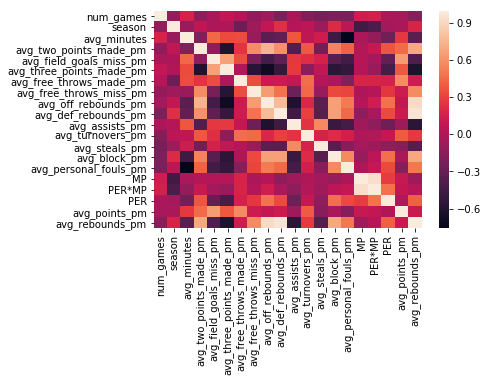

In [40]:
import seaborn as sns
sns.heatmap(ncaa_nba_pm.corr())

In [65]:
ncaa_nba_pm.corr()

#Although (with respect to PER), the majority of independent variables seem to be behaving as expected, 3 pointers made seem to
#be significantly negatively correlated with PER, along with assists and steals.

,num_games,season,avg_minutes,avg_two_points_made_pm,avg_field_goals_miss_pm,avg_three_points_made_pm,avg_free_throws_made_pm,avg_free_throws_miss_pm,avg_off_rebounds_pm,avg_def_rebounds_pm,avg_assists_pm,avg_turnovers_pm,avg_steals_pm,avg_block_pm,avg_personal_fouls_pm,MP,PER*MP,PER,avg_points_pm,avg_rebounds_pm
num_games,1.000000,-0.111295,0.175999,-0.122766,-0.015541,0.078533,0.024657,-0.114602,-0.053411,-0.195484,-0.009260,-0.173373,-0.215398,-0.198110,-0.194835,0.139083,0.157672,-0.020157,-0.032782,-0.146748
season,-0.111295,1.000000,-0.084026,0.070807,-0.003896,0.006232,-0.274014,-0.064716,0.082266,0.231849,0.019689,0.058072,-0.071305,0.206719,0.063948,-0.453994,-0.402573,-0.043306,-0.020009,0.181996
avg_minutes,0.175999,-0.084026,1.000000,-0.179528,0.440339,0.338227,0.345709,-0.088995,-0.331937,-0.314755,0.379232,0.070162,0.131195,-0.465834,-0.757224,-0.012277,-0.100690,-0.250031,0.272144,-0.339617
avg_two_points_made_pm,-0.122766,0.070807,-0.179528,1.000000,-0.120974,-0.605158,0.247551,0.582929,0.741900,0.600124,-0.383116,0.382337,-0.252099,0.549765,0.420847,0.014198,0.103441,0.373354,0.452854,0.693331
avg_field_goals_miss_pm,-0.015541,-0.003896,0.440339,-0.120974,1.000000,0.668427,0.347093,-0.217938,-0.436145,-0.328977,0.265746,0.230064,0.164102,-0.353261,-0.443169,0.023904,-0.046528,-0.306734,0.645580,-0.392444
avg_three_points_made_pm,0.078533,0.006232,0.338227,-0.605158,0.668427,1.000000,0.004274,-0.568770,-0.684084,-0.515180,0.274365,-0.135464,0.075834,-0.555647,-0.522471,0.030300,-0.081993,-0.428456,0.387481,-0.615024
avg_free_throws_made_pm,0.024657,-0.274014,0.345709,0.247551,0.347093,0.004274,1.000000,0.342721,0.116141,0.127960,0.098829,0.459427,0.031647,-0.005006,-0.163371,0.179779,0.181029,0.163445,0.579724,0.130167
avg_free_throws_miss_pm,-0.114602,-0.064716,-0.088995,0.582929,-0.217938,-0.568770,0.342721,1.000000,0.649430,0.481762,-0.259828,0.444998,-0.087566,0.331783,0.317493,-0.003314,0.028531,0.261714,0.123937,0.579214
avg_off_rebounds_pm,-0.053411,0.082266,-0.331937,0.741900,-0.436145,-0.684084,0.116141,0.649430,1.000000,0.784324,-0.607285,0.192336,-0.339653,0.660437,0.510944,0.023814,0.141381,0.477196,0.087037,0.918906
avg_def_rebounds_pm,-0.195484,0.231849,-0.314755,0.600124,-0.328977,-0.515180,0.127960,0.481762,0.784324,1.000000,-0.467802,0.301954,-0.357108,0.659796,0.449688,-0.121598,-0.028905,0.337814,0.118671,0.965434


,num_games,season,avg_minutes,avg_two_points_made_pm,avg_field_goals_miss_pm,avg_three_points_made_pm,avg_free_throws_made_pm,avg_free_throws_miss_pm,avg_off_rebounds_pm,avg_def_rebounds_pm,avg_assists_pm,avg_turnovers_pm,avg_steals_pm,avg_block_pm,avg_personal_fouls_pm,MP,PER*MP,PER,avg_points_pm,avg_rebounds_pm
count,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000
mean,34.793814,2013.979381,30.522780,0.129222,0.183844,0.039189,0.109958,0.037651,0.052219,0.142015,0.079043,0.062547,0.037137,0.030352,0.078743,1864.092784,23546.635052,11.563318,0.485969,0.194233
std,3.310143,0.803370,5.392941,0.042858,0.045174,0.028898,0.030708,0.016826,0.033883,0.051281,0.050610,0.017793,0.020338,0.031291,0.031453,1819.172609,27399.438386,3.953031,0.090212,0.080644
min,20.000000,2013.000000,7.481481,0.054027,0.043676,0.000000,0.030788,0.006158,0.008166,0.062181,0.004950,0.016010,0.006774,0.000716,0.034796,110.000000,362.500000,3.295455,0.272975,0.074414
25%,34.000000,2013.000000,28.684211,0.098826,0.155075,0.013547,0.088398,0.023927,0.021589,0.100309,0.045510,0.049908,0.024390,0.007547,0.060212,376.000000,3993.700000,8.500000,0.432734,0.126079
50%,35.000000,2014.000000,31.833333,0.121457,0.185430,0.036217,0.112532,0.035953,0.043172,0.136084,0.058733,0.061096,0.032787,0.018987,0.073151,1347.000000,12322.500000,10.900000,0.483771,0.180473
75%,36.000000,2015.000000,34.378378,0.153005,0.216693,0.063272,0.130833,0.049327,0.084158,0.178602,0.097372,0.074167,0.044744,0.039326,0.085478,2797.000000,33351.600000,13.700000,0.545780,0.261188
max,40.000000,2015.000000,39.942857,0.251212,0.289617,0.114169,0.179487,0.083115,0.131478,0.275742,0.235812,0.108379,0.147170,0.117881,0.208520,8862.000000,138503.600000,24.374669,0.790855,0.394434


Technical Analysis:

Here is where the models are created. I created a Linear Regression Model and did both Train-Test-Split and Kfold, then I did Random Forest Regression. For each of these models, I optimized a parameter based on R2 and Mean Squared Error, then compared the models to each other to determine the ideal one to use.

In [84]:
X = ncaa_nba_pm[['avg_points_pm', 'avg_field_goals_miss_pm', 'avg_rebounds_pm', 'avg_assists_pm']]
Y = ncaa_nba_pm['PER']

#With the linear, I combined some of the metrics and overall used fewer predictors because I wanted to make my predictors
#As independent from each other as possible (For example, Off rebounds and Def Rebounds are highly correlated so I combined them into rebounds)

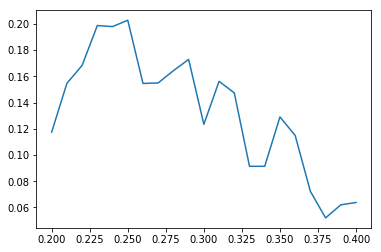

In [85]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt

mse_list = []
r_list = []
n_list = []
for n in range(20,41):
    x_train, x_test, y_train, y_test = train_test_split(X,Y, random_state = 22, test_size = n/100)
    lr = LinearRegression()
    lr.fit(x_train, y_train)
    y_pred = lr.predict(x_test)
    mse=metrics.mean_squared_error(y_test, y_pred)
    r = lr.score(x_test, y_test)
    mse_list.append(mse)
    r_list.append(r)
    n_list.append(n/100)
plt.plot(n_list,r_list)

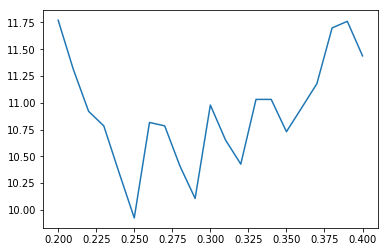

In [86]:
plt.plot(n_list,mse_list)

In [94]:
x_train, x_test, y_train, y_test = train_test_split(X,Y, random_state = 22, test_size = .25)
lr = LinearRegression()
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)
mse=metrics.mean_squared_error(y_test, y_pred)
r = lr.score(x_test, y_test)
print("The MSE is " + str(mse))
print("The R2 value is " + str(r))

#With this test size, the MSE seems pretty low (relative to the default MSE below) but there might be more variance to our model since it is only 1 split.
#Next we'll look into K fold

The MSE is 9.924484371509239
The R2 value is 0.20278141652206705


In [95]:
print(lr.coef_)

[  7.51838345 -31.86142245   9.30726453  -0.3101035 ]


In [88]:
X = ncaa_nba_pm[['avg_points_pm', 'avg_field_goals_miss_pm', 'avg_rebounds_pm', 'avg_assists_pm']]
Y = ncaa_nba_pm['PER']

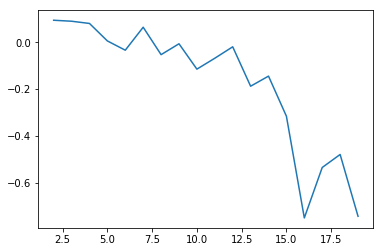

In [89]:
from sklearn.model_selection import cross_val_score
from sklearn import model_selection
import numpy as np

lr = LinearRegression()
mse_list = []
r_list = []
n_list = []
for n in range(2,20):
    kf = model_selection.KFold(n_splits=n, shuffle=True, random_state = 33)
    mse = np.mean(-cross_val_score(lr, X, Y, cv=kf, scoring='neg_mean_squared_error'))
    r = np.mean(cross_val_score(lr, X, Y, cv=kf))
    mse_list.append(mse)
    r_list.append(r)
    n_list.append(n)
plt.plot(n_list,r_list)

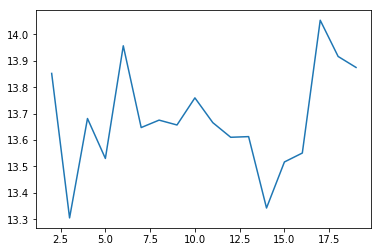

In [90]:
plt.plot(n_list,mse_list)

In [93]:
kf = model_selection.KFold(n_splits=3, shuffle=True, random_state = 33)
mse = np.mean(-cross_val_score(lr, X, Y, cv=kf, scoring='neg_mean_squared_error'))
r = np.mean(cross_val_score(lr, X, Y, cv=kf))
print("The MSE is " + str(mse))
print("The R2 is " + str(r))

The mse is 13.30508487330375
The R2 is 0.08970750311034666


In [48]:
y_avg = [y_train.mean()]*len(Y)

In [49]:
metrics.mean_squared_error(Y, y_avg)
#Based on this both of them have lower MSE than the baseline, but they both also have low R2 values.

15.49763030270223

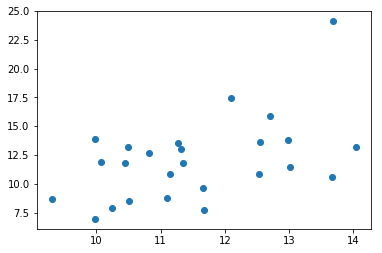

In [96]:
#Lets try random forest!
X = ncaa_nba_pm[['avg_two_points_made_pm', 'avg_field_goals_miss_pm', 'avg_three_points_made_pm', 'avg_free_throws_made_pm', 'avg_free_throws_miss_pm', 'avg_off_rebounds_pm', 'avg_def_rebounds_pm', 'avg_assists_pm', 'avg_turnovers_pm', 'avg_steals_pm', 'avg_block_pm', 'avg_personal_fouls_pm']]
Y = ncaa_nba_pm['PER']

#Since with random forest there is less concern about having correlated independent variables, I used more predictors

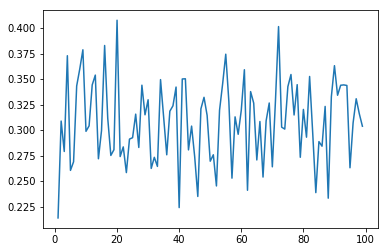

In [97]:
from sklearn.ensemble import RandomForestRegressor
r_list = []
mse_list = []
n_list = []
for n in range(1, 100):
    rf = RandomForestRegressor(n_estimators = 100, max_depth = n)
    x_train, x_test, y_train, y_test = train_test_split(X,Y, random_state = 50)
    rf.fit(x_train,y_train)
    y_pred = rf.predict(x_test)
    r = rf.score(x_test, y_test)
    mse = metrics.mean_squared_error(y_pred, y_test)
    n_list.append(n)
    mse_list.append(mse)
    r_list.append(r)
plt.plot(n_list, r_list)

#Optimizing on max depth of each tree in the forest

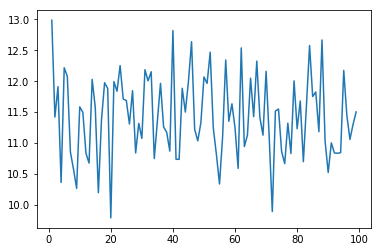

In [98]:
plt.plot(n_list, mse_list)

In [99]:
rf = RandomForestRegressor(n_estimators = 100, max_depth = 4)
x_train, x_test, y_train, y_test = train_test_split(X,Y, random_state = 50)
rf.fit(x_train,y_train)
y_pred = rf.predict(x_test)
r = rf.score(x_test, y_test)
mse = metrics.mean_squared_error(y_pred, y_test)
print("The MSE is " + str(mse))
print("The R2 value is " + str(r))

The MSE is 11.082855636951546
The R2 value is 0.32918540294648796
